In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pandas as pd

from keras import models
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.metrics import TopKCategoricalAccuracy
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.applications.resnet_v2 import ResNet50V2

2022-11-12 00:31:45.150546: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2022-11-12 00:31:45.868335: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-11-12 00:31:45.868440: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-11-12 00:31:45.868450: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the m

In [3]:
train_dir = 'images'
test_dir = 'test'

dfTrain = pd.read_csv("trainSplit.csv").astype(str)
dfTest = pd.read_csv("validSplit.csv").astype(str)

In [4]:
train_data = ImageDataGenerator(rescale=1/255, rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

validation_data = ImageDataGenerator(rescale=1/255)


train_generator = train_data.flow_from_dataframe(dfTrain,
                                                 directory=train_dir,
                                                 y_col = "hotel_id",
                                                 x_col= "image_id",
                                                 target_size = (256, 256),
                                                 batch_size=128,
                                                 class_mode="categorical")

validation_generator = validation_data.flow_from_dataframe(dfTest,
                                                      directory=test_dir,
                                                      y_col = "hotel_id",
                                                      x_col= "image_id",
                                                      target_size = (256, 256),
                                                      batch_size=128,
                                                      class_mode="categorical")

Found 27127 validated image filenames belonging to 1376 classes.
Found 6178 validated image filenames belonging to 1376 classes.


# MODEL METRICS (FUNCTIONS)

In [10]:
def graphProgress(history):    
    acc = history.history['top_k_categorical_accuracy']
    val_acc = history.history['val_top_k_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

def runModel(model, epochs=30, steps=100):
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5), metrics=[TopKCategoricalAccuracy(k=5)])
    #model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=[TopKCategoricalAccuracy(k=5)])
    history = model.fit(train_generator, steps_per_epoch=steps, epochs=epochs, validation_steps = 50, validation_data=validation_generator,verbose=1)
    graphProgress(history)
    return history

In [11]:
new_base = ResNet50V2(weights='imagenet',
                  include_top=False,
                  input_shape=(256, 256, 3))
new_base.trainable = False

Epoch 1/50
80/80 [==============================] - 170s 2s/step - loss: 7.0062 - top_k_categorical_accuracy: 0.1585 - val_loss: 6.8805 - val_top_k_categorical_accuracy: 0.2011
Epoch 2/50
80/80 [==============================] - 151s 2s/step - loss: 6.7146 - top_k_categorical_accuracy: 0.1981 - val_loss: 7.1903 - val_top_k_categorical_accuracy: 0.2265
Epoch 3/50
80/80 [==============================] - 151s 2s/step - loss: 6.5486 - top_k_categorical_accuracy: 0.2156 - val_loss: 6.8827 - val_top_k_categorical_accuracy: 0.2372
Epoch 4/50
80/80 [==============================] - 150s 2s/step - loss: 6.3908 - top_k_categorical_accuracy: 0.2248 - val_loss: 7.1277 - val_top_k_categorical_accuracy: 0.2444
Epoch 5/50
80/80 [==============================] - 150s 2s/step - loss: 6.3009 - top_k_categorical_accuracy: 0.2339 - val_loss: 6.8344 - val_top_k_categorical_accuracy: 0.2477
Epoch 6/50
80/80 [==============================] - 149s 2s/step - loss: 6.1631 - top_k_categorical_accuracy: 0.254

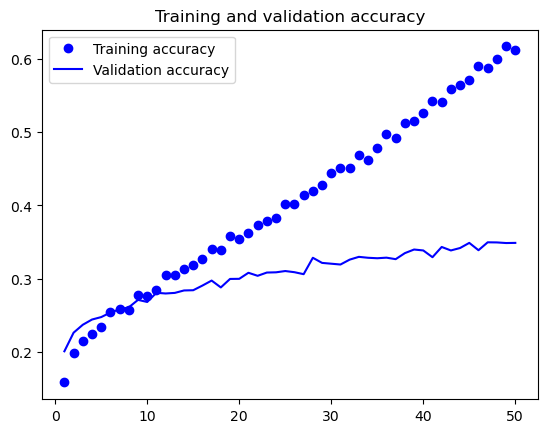

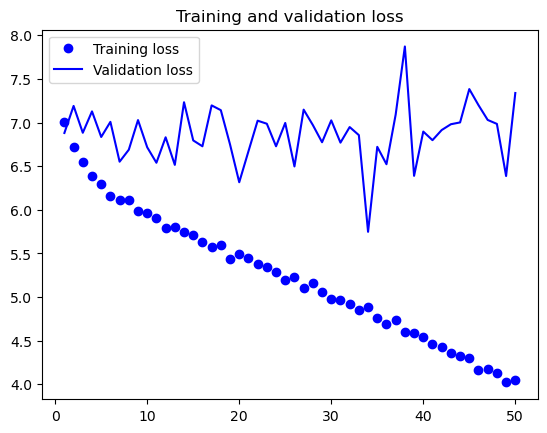

/opt/conda/lib/python3.7/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


In [13]:
model = models.Sequential([
                           new_base,
                           Flatten(),
                           Dense(512,activation='relu'),
                           Dense(1376, activation='softmax'),                 
                          ])
history = runModel(model,50,80)
model.save("DosAug")

In [8]:
print(history.params)

{'epochs': 50, 'steps': 80, 'verbose': 1, 'do_validation': True, 'metrics': ['loss', 'top_k_categorical_accuracy', 'val_loss', 'val_top_k_categorical_accuracy']}


In [ ]:
#resumedModel = tf.keras.models.load_model('DosAug')
runModel(model,100,80)

Epoch 1/100
80/80 [==============================] - 172s 2s/step - loss: 3.9468 - top_k_categorical_accuracy: 0.6292 - val_loss: 6.8109 - val_top_k_categorical_accuracy: 0.3554
Epoch 2/100
80/80 [==============================] - 152s 2s/step - loss: 3.9007 - top_k_categorical_accuracy: 0.6350 - val_loss: 7.3994 - val_top_k_categorical_accuracy: 0.3524
Epoch 3/100
80/80 [==============================] - 153s 2s/step - loss: 3.8789 - top_k_categorical_accuracy: 0.6381 - val_loss: 7.6895 - val_top_k_categorical_accuracy: 0.3557
Epoch 4/100
80/80 [==============================] - 152s 2s/step - loss: 3.8114 - top_k_categorical_accuracy: 0.6476 - val_loss: 7.1389 - val_top_k_categorical_accuracy: 0.3509
Epoch 5/100
80/80 [==============================] - 152s 2s/step - loss: 3.7857 - top_k_categorical_accuracy: 0.6553 - val_loss: 7.2293 - val_top_k_categorical_accuracy: 0.3584
Epoch 6/100
80/80 [==============================] - 150s 2s/step - loss: 3.6994 - top_k_categorical_accuracy: